# read all forcings and interpolate using model algorithm and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas

In [9]:
# make all plots larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 8]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300

In [70]:
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    newt = np.mod(time, 365.)
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(0.5, 12.5, 13) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [71]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "spline"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "spline"

In [72]:
# read environmental forcings
MLDfile = pandas.read_csv('MLD2015_R1.csv')


NOXfile = pandas.read_csv('NO2NO3_R1.csv')

SiOXfile = pandas.read_csv('SiOH_R1.csv')

SSTfile = pandas.read_csv('SST_R1.csv')

PARfile = pandas.read_csv('PAR_R1.csv')

## important choice here:
# mean or median of monthly values

In [73]:
MLD_monthly_median = MLDfile.groupby('month').mean() 
MLD = list(MLD_monthly_median['MLD'])
MLD.append(MLD[0])

NOX_monthly_median = NOXfile.groupby('month').mean() 
NOX = list(NOX_monthly_median['NO2NO3'])
NOX.append(NOX[0])

SiOX_monthly_median = SiOXfile.groupby('month').mean() 
SiOX = list(SiOX_monthly_median['SiOH'])
SiOX.append(SiOX[0])

SST_monthly_median = SSTfile.groupby('month').mean()
SST = list(SST_monthly_median['SST'])
SST.append(SST[0])

PAR_monthly_median = PARfile.groupby('month').mean()
PAR = list(PAR_monthly_median['PAR'])
PAR.append(PAR[0])

'''
PARfile = pandas.read_csv('CARIACO_forcing01/PAR')
PAR = list(PARfile['value'])
PAR.append(PARfile['value'][0])''';

In [74]:
PAR

[47.2945991352899,
 50.42223261717785,
 54.58869948174106,
 53.912132782939196,
 54.065199456876144,
 52.74773272763317,
 54.89549949631328,
 56.28513289565066,
 54.665266152044445,
 52.28399937227368,
 48.50963252633422,
 45.4966323832244,
 47.2945991352899]

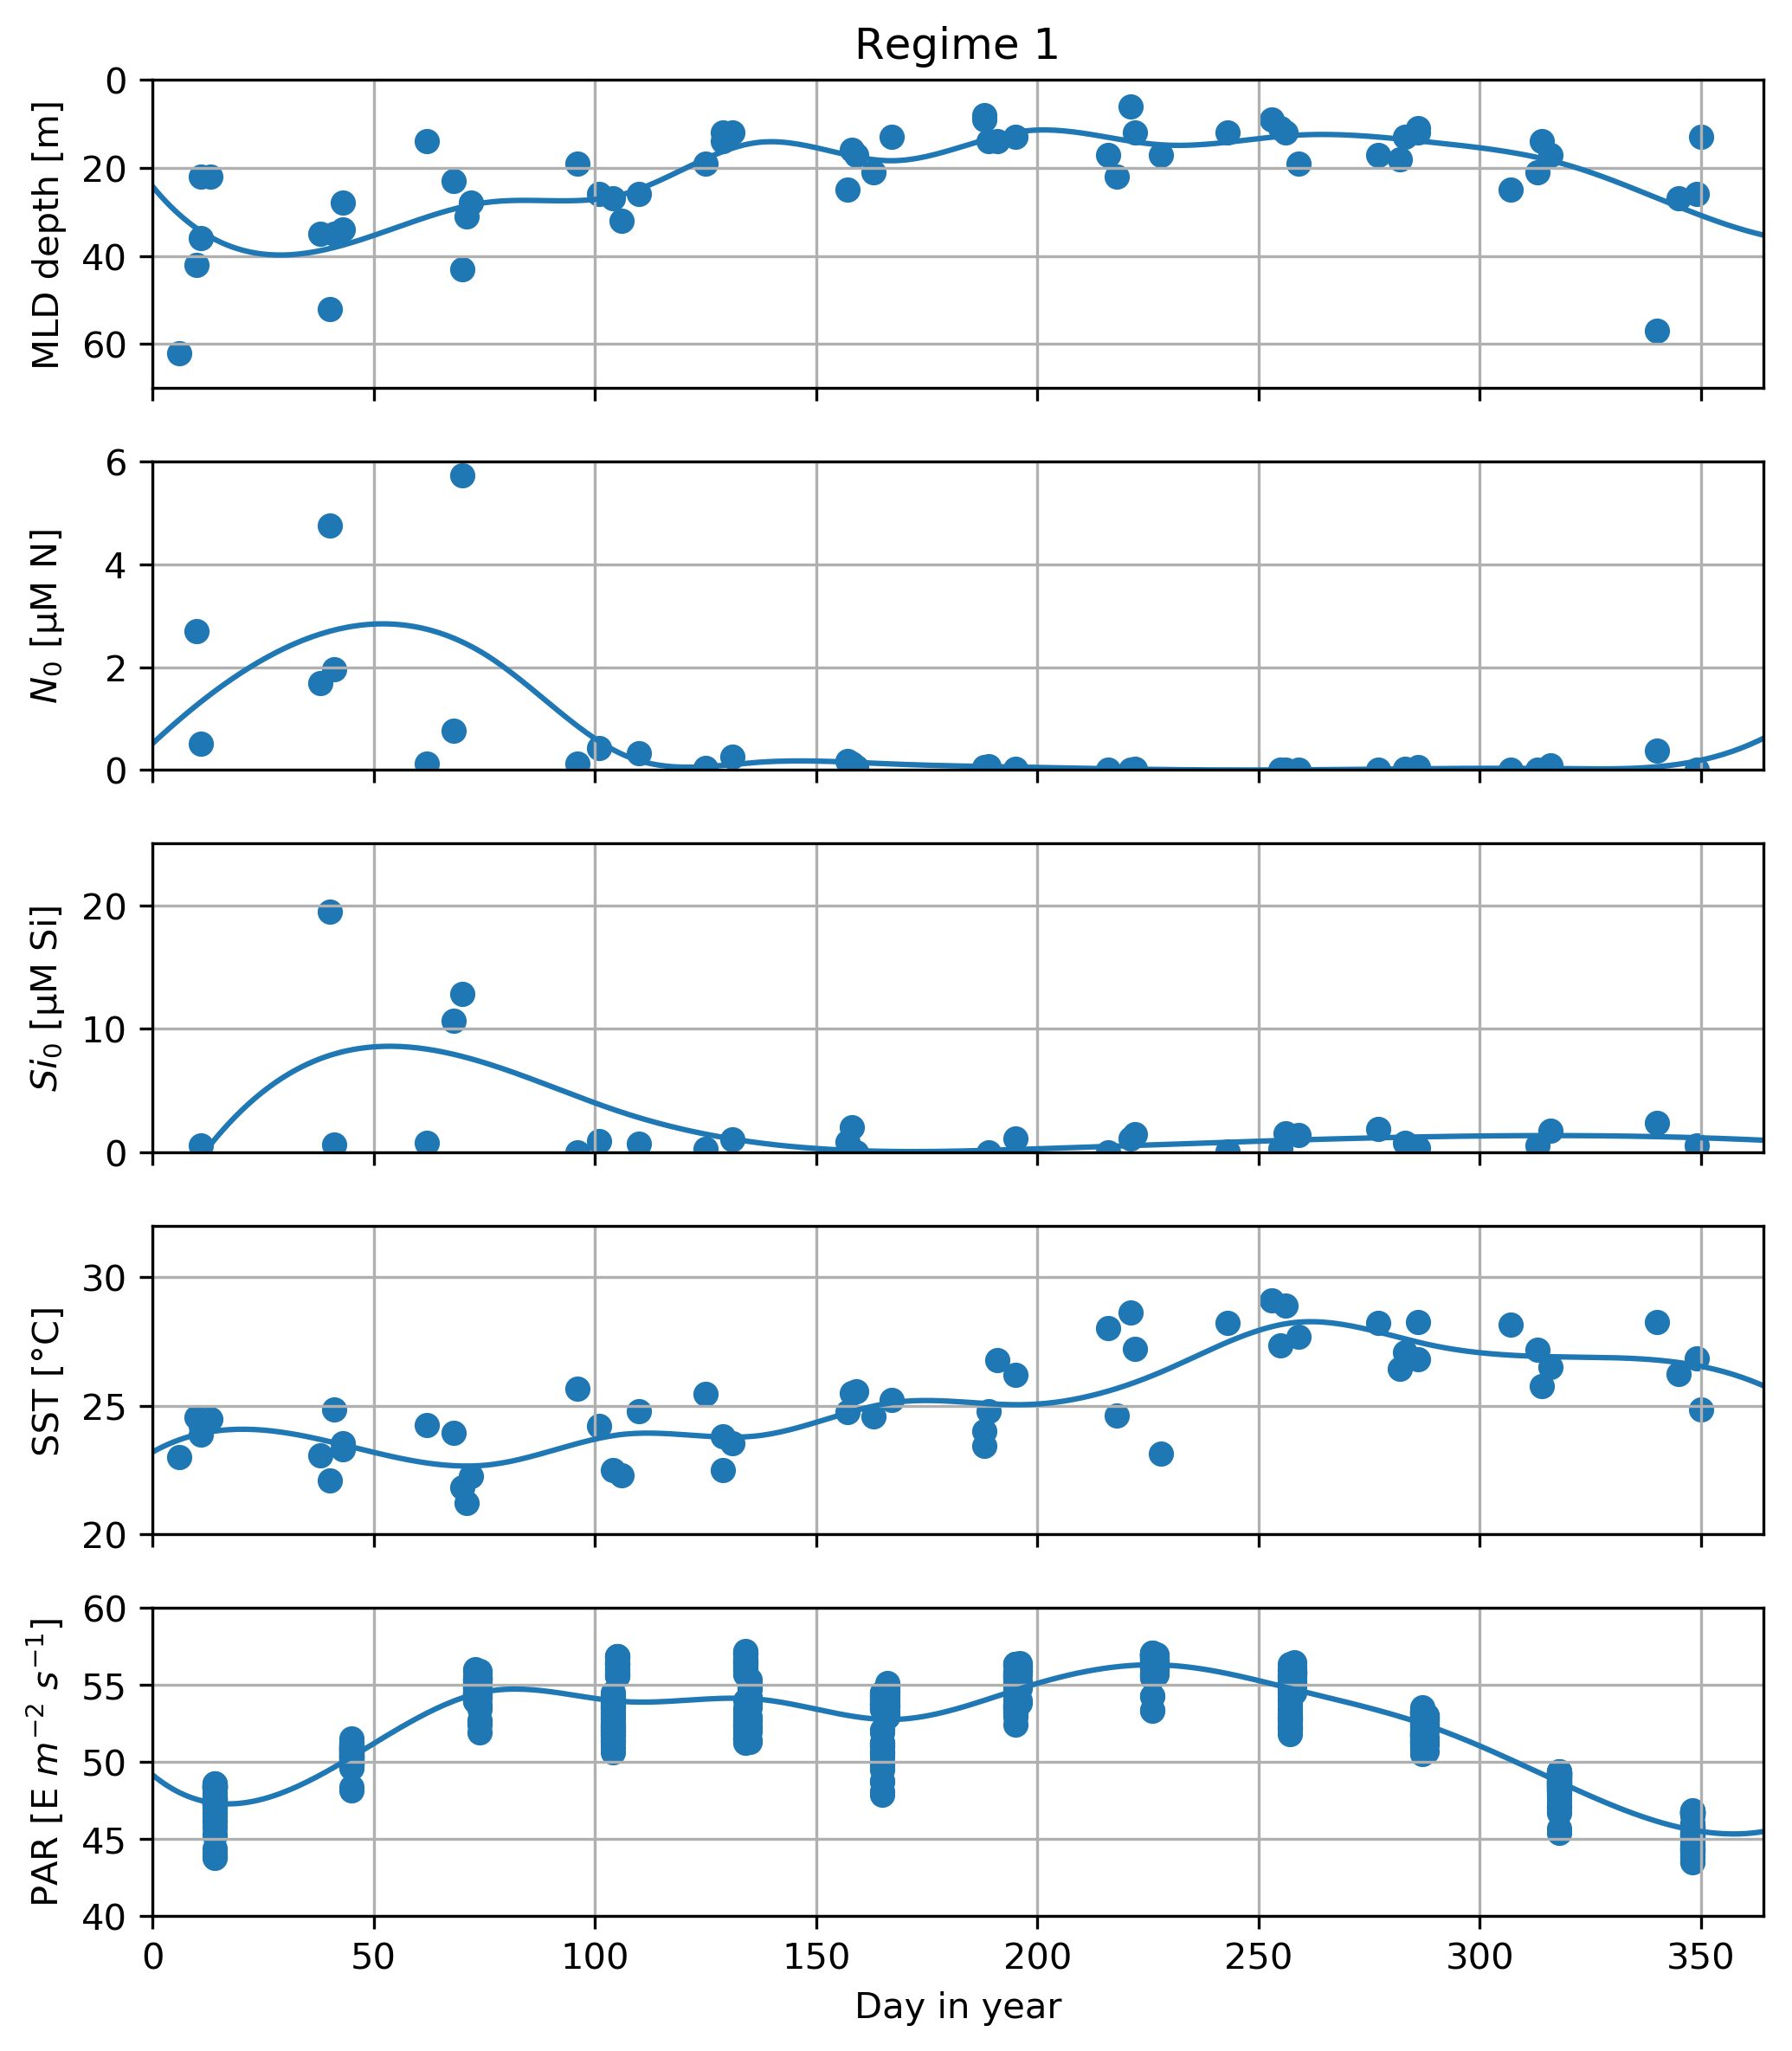

In [76]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD = dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)

forcing_NOX = dailyinterp(NOX, t_forcingplot, kind=kindmld, k=kmld, s=smld)

forcing_SiOX = dailyinterp(SiOX, t_forcingplot, kind=kindsi0x, k=kmld, s=ssi0x)

forcing_SST = dailyinterp(SST, t_forcingplot, kind=kindmld, k=kmld, s=smld)

forcing_PAR = dailyinterp(PAR, t_forcingplot, kind=kindmld, k=kmld, s=smld)#, kind=kindpar, k=kpar, s=spar)



fig, (fx1, fx2, fx3, fx4, fx5) = plt.subplots(5, 1, sharex='col', sharey='row')
# MLD
fx1.plot(t_forcingplot, forcing_MLD)
fx1.scatter(MLDfile['yday'], MLDfile['MLD'])
fx1.set_ylim(0,70)
fx1.set_ylabel('MLD depth [m]')
fx1.set_title('Regime 1')
fx1.invert_yaxis()
fx1.grid()

# NOX
fx2.plot(t_forcingplot, forcing_NOX)
fx2.scatter(NOXfile['yday'], NOXfile['NO2NO3'])
fx2.set_ylim(0,6)
fx2.set_ylabel('$N_0$ [µM N]')
fx2.grid()

# SiOX
fx3.plot(t_forcingplot, forcing_SiOX)
fx3.scatter(SiOXfile['yday'], SiOXfile['SiOH'])
fx3.set_ylim(0,25)
fx3.set_ylabel('$Si_0$ [µM Si]')
fx3.grid()

# SST
fx4.set_ylabel('SST [°C]')
fx4.plot(t_forcingplot, forcing_SST)
fx4.scatter(SSTfile['yday'], SSTfile['SST'])
fx4.set_ylim(20,32)
fx4.grid()

# PAR
fx5.set_ylabel('PAR [E $m^{−2}$ $s^{−1}$]')
fx5.plot(t_forcingplot, forcing_PAR)
fx5.scatter(PARfile['yday'], PARfile['PAR'])
fx5.set_ylim(40,60)
fx5.grid()


fx5.set_xlabel('Day in year')

fig.align_ylabels()
plt.margins(x=0)
plt.tight_layout()
plt.show()

#titles on the side!
#labels as big as possible
#more numbers on axis (major ticks + minor ticks)
#lines thicker
#plot original data with interpolation (scattered raw data (or average +- bars, standard errors)), perhaps boxplots or cut off top
#put letters size all the same
# put NO2+NO3 instead of N, for all chemicals
# start on origin, no gaps